In [119]:
pip install pandas matplotlib numpy scikit-learn scipy seaborn 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Preparing the data

In [120]:
# 1. Firstly, before we construct the CRO algorithm we will need to load in our data that we will train the model with
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

# Load in data from CSV file, I used Kaggle for this
data_csv = pd.read_csv("GaltonFamilies.csv")

In [121]:
# Remember that regression uses only quantitative variables, so we should filter columns with any non number columns

# Identify numerical columns
numerical_columns = data_csv.select_dtypes(include=['number']).columns

# Create a new DataFrame with only numerical columns
data_csv = data_csv[numerical_columns]


# Testing when looking at only specified columns
columns_to_keep = ['father', 'childHeight']
data_csv = data_csv[columns_to_keep]


In [122]:
data_csv.head

<bound method NDFrame.head of      father  childHeight
0      78.5         73.2
1      78.5         69.2
2      78.5         69.0
3      78.5         69.0
4      75.5         73.5
..      ...          ...
929    62.0         64.0
930    62.0         62.0
931    62.0         61.0
932    62.5         66.5
933    62.5         57.0

[934 rows x 2 columns]>

# Clustering the data

In [159]:
# We will cluster our data into approximated points with the following logic:

"""
Choose an arbitrary dimension, then go from intervals [min < X < max], look at all data points within interval (X#, X#+1) then generate averages for each cluster
"""

# First sort our data set given the row we choose (usually the variable we are most interested in)
chosen_column = 'childHeight'

# Sort the dataset by the chosen column
data_csv_sorted = data_csv.sort_values(by=chosen_column)
chunk_size = 50 # amount of desired points in each chunk



# Pseudocode below
"""
for chunk in chunks:
    cluster_list = makeClusters(chunk)
    aprox_vectors = []
    
    for cluster in cluster_list:
        aprox_vectors.append(cluster.mean)

return aprox_vectors
"""

# A chunk is defined as a group of data points with relatively close proximity
def generate_chunks(data):
    chunk_list = []
    index = 0
    while (index + chunk_size) < len(data):
        chunk_list.append(data[index:index+chunk_size])
        index += chunk_size

    return chunk_list


# Function to determine the optimal number of clusters
def determine_optimal_cluster_count(data, max_clusters=10, sensitivity=0.75):
    if len(data) <= 1:
        return 1  # Can't cluster if there's only one point
    distortions = []
    for k in range(1, min(len(data), max_clusters) + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Heuristic: choose the number of clusters where the reduction in inertia decreases significantly
    k_opt = 1
    for i in range(1, len(distortions)):
        if distortions[i-1] - distortions[i] < sensitivity * (distortions[0] - distortions[-1]):
            k_opt = i
            break
    return k_opt

def generate_cluster_averages(chunk, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(chunk)
    cluster_centers = kmeans.cluster_centers_
    # print(num_clusters, ": ", cluster_centers.tolist())
    return cluster_centers.tolist()





# Generate chunks
chunks = generate_chunks(data_csv_sorted)

# Initialize list to store cluster averages
cluster_averages = []

# Generate cluster averages for each chunk
for chunk in chunks:
    cluster_averages.extend(generate_cluster_averages(chunk, determine_optimal_cluster_count(chunk)))

print(cluster_averages)



[[67.32, 60.122], [68.338, 61.896], [68.978, 62.658], [68.876, 63.192], [68.73, 63.910000000000004], [69.274, 64.576], [68.664, 65.0], [69.28, 65.582], [68.804, 66.004], [69.068, 66.756], [69.242, 67.222], [69.144, 67.996], [69.244, 68.568], [70.08, 69.142], [69.638, 69.988], [69.904, 70.466], [69.408, 71.144], [70.232, 72.246]]


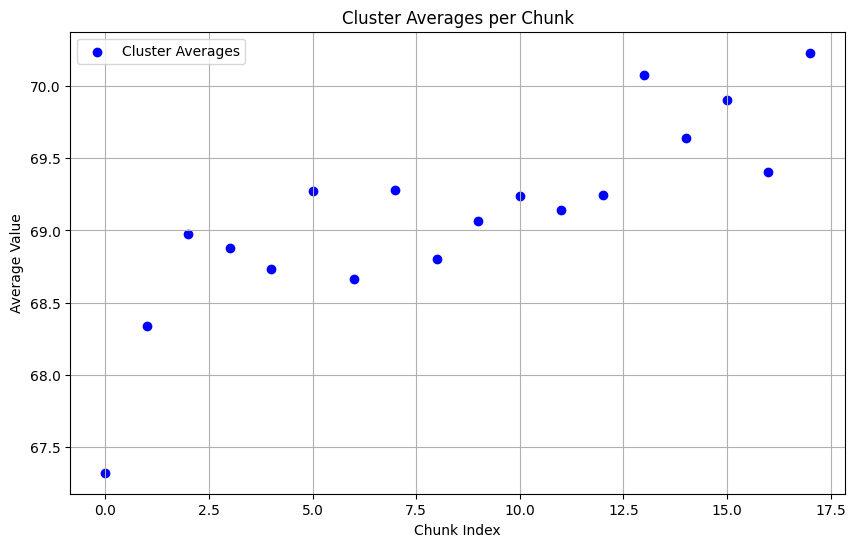

In [160]:
# Plotting the cluster averages
x_values = range(len(cluster_averages))
y_values = [avg[0] for avg in cluster_averages]  # Assuming cluster averages are 1D, adjust if they are multidimensional

plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, c='blue', marker='o', label='Cluster Averages')
plt.xlabel('Chunk Index')
plt.ylabel('Average Value')
plt.title('Cluster Averages per Chunk')
plt.legend()
plt.grid(True)
plt.show()

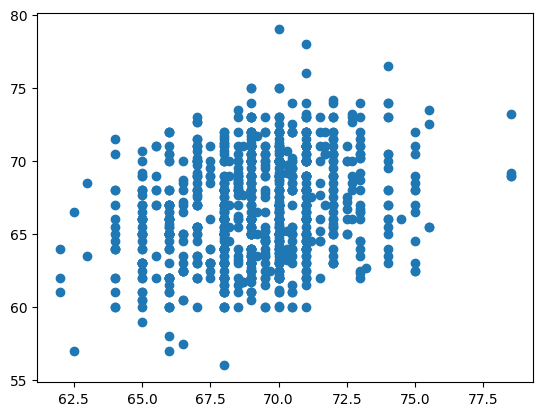

In [158]:
plt.plot(data_csv["father"], data_csv["childHeight"], 'o')

# Connecting approximation points

In [125]:
# Connect each cluster with another node that has the best (density - distance) value, lets define the functions below...

density_bias = 1
distance_bias = 1

def density_value(p1, p2):
    # calculated via
    # (# of data in area between two points) / (size of the area) * density_bias
    pass

def distance_value(p1, p2):
    # calculated via
    # point distance * distance_bias
    pass